# Lab Six: Convolutional Network Architectures

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Dataset Selection](#data)<br>
  1.1 [Business Case](#business)<br>
 2. [Preparation](#prep)<br>
  2.1 [Metric](#metric)<br>
  2.2 [Test-Train Split](#split)<br>
 3. [Modeling](#modeling)<br>
  3.1 [CNN](#cnn)<br>
  3.2 [Different Architectures](#architectures)<br>
  ... 3.2.1 [LeNet Style](#LeNet)<br>
  ... 3.2.2 [Ensembles](#Ensembles)<br>
  3.3 [Visualize Final Results](#visualize)<br>
  3.4 [Compare the Performance](#compare)<br>
 4. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analyses](#additional_analysis)<br>
  ... 4.1.1 [Class Activation Maps](#CAM)<br>
  ... 4.1.2 [Custom Image Generator](#image_generator)<br>
  4.2 [Transfer Learning](#Transfer_Learning)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="data"></a>

## Data Selection

> Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

For this project we chose to use a [random sample of NIH Chest X-Ray Dataset](https://www.kaggle.com/nih-chest-xrays/sample/home). This dataset contains 5606 images that have been preprocessed to be a uniform size of $1024 \times 1024$ and also includes a csv containing the labels associated with the x-ray images. This dataset includes X Ray images of patients with 14 different diseases. We will start with a binary classification, sick or not sick.

For later parts of this project we will use the [full X-Ray data set](https://www.kaggle.com/nih-chest-xrays/data#Data_Entry_2017.csv). We will also try a multi-class classification for later parts of the project. 

<a id="business"></a>

### Business Case

Although this project doesn't explicetly request a business case, a clear understanding of how we expect our model to be used is helpful for framing many of the later sections. 

We expect our model to be used as a means to pre-screen X-Rays taken before they are analyzed by a trained radiologist. We do not expect our model to be used as a standalone means of diagnosing patients. Although some CNNs may perform better than radiologists in academic settings, we have not yet seen any that have passed trials for clinical use (but they may exist). More importantly, we feel that most patients will simply be more comfortable with the diagnosis if a trained Dr is included in the loop. Therefore, we envision this model being one tool that a Dr can use to aid diagnosis and not a replacement for a Dr.

<a id="preparation"></a>

## Preparation

Before we define the metric and decide on a test-train split, we need to make sure all of the X-Ray images are the same format. The images are all the same size, but we will need to make sure all of them are black and white as well as flipping some of the images along the vertical axis to account for the different persepctives used (patient laying on back or front). While we are doing this we will also resize the images to a smaller size to make our testing run quicker. If we use left-right flipping as a part of our data expansion, the initial flipping will be unnecessary. However, we wanted to start from a common initial point to (hopefully) get a better of idea how the individual variables affect our model's performance.

We have also taken the 2D Fourier transformation of the images and saved the transformations as numpy arrays as well as an image of the transforms. We may augment our model with the transformed space in order to see if there is any increase in performance with the additional "momentum" space information.

Finally, we will also need to do some work on the target to make it into a binary classification problem. Initially we will only try to classify the instances based on whether the patient had pnemonia or not. In the future we can also look at a binary classification of whether the patient had any disease or not. Finally, we can also try to a multi-classification model to predict each of the diseases individually. However, given that we only have ~5,000 images (before expansion), we do not think this model would perform very well.

In [9]:
import pandas as pd

# first read in the dataframe that gives us the perspective
df = pd.read_csv('sample_labels.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


First we will resize and save the images. This only needs done once so we put it behing an if statement. We have also placed the Fourier transform behind an if statement since we save the numpy arrays to disk and will read them in later as needed. Since taking FFTs are quick, we are not sure whether or not it is quicker to read from disk or to take the fft each time it is needed.

In [10]:
# resize and save the images
import os
from PIL import Image
import time
from IPython.display import display, clear_output

savefigs=False

if savefigs:
    size = 1024
    base = os.getcwd()
    full = os.path.join(base,'sample/images/')
    t_start = time.time()

    size_dict = {64:  '64x64',
             128: '128x128',
             256: '256x256',
             512: '512x512',
             1024:'1024x1024'}

    i=0
    errors = 0
    for (dirpath, dirnames, filenames) in os.walk(full):
        for file in filenames:
            # get the info from the df
            # possibly a more efficient way to do this, but this works
            row = df[df['Image Index']==str(file)]
            if row['View Position'].values[0] == 'PA':
                # flip the PA
                img = Image.open(os.path.join(full, file)).convert('L').transpose(Image.FLIP_LEFT_RIGHT)
            elif row['View Position'].values[0] == 'AP':
                # keep AP
                img = Image.open(os.path.join(full, file)).convert('L')
            else:
                # in case there is an error
                img = Image.open(os.path.join(full, file)).convert('L')
                error += 1
                with open('sample/proj.dat', 'a+') as f:
                    f.write('Could not find image {} in the df\n'.format(file))
                    f.write(str(row['View Position']=='PA'))
            o_size = img.size
            s = size, size
            img.thumbnail(s)
            img.save(os.path.join(base, 'sample', size_dict[size], file))
            clear_output(wait=True)
            display('finished #{}: {}: Original Dims ({} {}) : Finial Dims ({} {}): time {:.2f} seconds'.format(i, file, o_size[0], o_size[1], img.size[0], img.size[1], time.time()-t_start))
            i+=1
        print('{} files missed, check proj.dat file'.format(errors))

In [3]:
# now the Fourier transforms in case we use that information.
import numpy as np
import os
from PIL import Image
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

save_fft = False
save_fft_image = False

if save_fft:
    base = os.getcwd()
    print(base)
    t_start = time.time()

    size_dict = {64:  '64x64',
                 128: '128x128',
                 256: '256x256',
                 512: '512x512',
                 1024:'1024x1024'}

    #sizes = [64, 128, 256, 512, 1024]
    sizes = [64]
    for size in sizes:

        read_dir = os.path.join(base, 'sample', size_dict[size])
        write_dir = read_dir+'_fft'

        i = 0
        for (dirpath, dirnames, filenames) in os.walk(read_dir):
            for file in filenames:
                # read image, take fft, save fft as np object
                img = Image.open(os.path.join(read_dir, file))
                fft = np.fft.fft2(img)
                fft_abs = np.abs(fft)
                f, _ = os.path.splitext(file)
                np.save(write_dir+'/'+f+'.fft', fft)

                if save_fft_image:
                    # save image of fft, this is fairly slow
                    fig, ax = plt.subplots(figsize=(5,5))
                    im = ax.imshow(fft_abs, cmap='hot', norm=LogNorm(vmin=0.1))
                    ax.set(xticks=[], yticks=[], title=file)
                    cb = fig.colorbar(im)
                    fig.savefig(os.path.join(write_dir, file))
                    plt.close(fig)

                clear_output(wait=True)
                display('finished #{}: {}: size {}: time {:.2f} seconds'.format(i, file, size, time.time()-t_start))
                i+=1

Now we will make the target labels we will use. First we will make a target that is a label of whether or not a patient is sick with any of the 14 illnesses or not. We also create a target that is a label of whether or not a patient has pneumonia and disregards the other illnesses. Finally, we create a target that has an element representing each of the 14 illnesses for use with the multi-class classification.

In [46]:
import numpy as np

# check if the frame contains 'No Finding' True if the patient was sick, False if not
y_sick = (~df['Finding Labels'].str.contains('No Finding'))*1

# now check for pneumonia, True if patient has pneumonia, False else
y_pneumonia = (df['Finding Labels'].str.contains('Pneumonia'))*1


# now make target for all diseases

disease_list = ['Hernia', 'Pneumonia', 'Fibrosis', 'Edema', 'Emphysema', 'Cardiomegaly', 'Pleural_Thickening',
                'Consolidation', 'Pneumothorax', 'Mass', 'Nodule', 'Atelectasis', 'Effusion', 'Infiltration', 'No Finding']

def disease_to_list(string, full_results = disease_list):
    '''Function to generate a list of the different diseases each patient has
    Inputs
    string: the string containing the diseases, ie df['Finding Labels']
    full_results: the list of all possible diseases used for the indices in the resulting list
    Returns
    list: a list with False if the patient didn't have the disease and True if the patient did. Indices based on full_results
    '''
    diseases = string.split('|')
    result = [False]*len(full_results)
    
    for d in diseases:
        result[full_results.index(d)] = True
    return result

y_all_l = df['Finding Labels'].apply(disease_to_list) # series version of .apply(). This returns a pd.series of lists
y_all = pd.DataFrame(y_all_l.tolist(), columns = disease_list) # convert to a pd.dataframe
y_all = y_all.astype(int)

# now check that the totals match kaggle https://www.kaggle.com/nih-chest-xrays/sample
y_all.sum(axis=0)

Hernia                  13
Pneumonia               62
Fibrosis                84
Edema                  118
Emphysema              127
Cardiomegaly           141
Pleural_Thickening     176
Consolidation          226
Pneumothorax           271
Mass                   284
Nodule                 313
Atelectasis            508
Effusion               644
Infiltration           967
No Finding            3044
dtype: int64

In [48]:
# find the percentages of each group:

for i, v in y_all.sum(axis=0).iteritems():
    print('class {}; number {}; percentage {:.3f}'.format(i, v, v/df.shape[0]*100))

class Hernia; number 13; percentage 0.232
class Pneumonia; number 62; percentage 1.106
class Fibrosis; number 84; percentage 1.498
class Edema; number 118; percentage 2.105
class Emphysema; number 127; percentage 2.265
class Cardiomegaly; number 141; percentage 2.515
class Pleural_Thickening; number 176; percentage 3.139
class Consolidation; number 226; percentage 4.031
class Pneumothorax; number 271; percentage 4.834
class Mass; number 284; percentage 5.066
class Nodule; number 313; percentage 5.583
class Atelectasis; number 508; percentage 9.062
class Effusion; number 644; percentage 11.488
class Infiltration; number 967; percentage 17.249
class No Finding; number 3044; percentage 54.299


<a id="Metric"></a>

### Metric

> __[15 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

For this project we chose to use two metrics. 

- First, the F1 score. This metric allows us to account for false positives as well as false negatives, which improves over a simple accuracy. Although a more in-depth metric, such as a custom cost matrix, may allow for finer tuning of the performace of our model, it removes the ability for us to compare our model with others.  

- A custom metric. Since our model will be used to pre-filter X-Rays we will need to make sure that the model catches absolutely all of the patients that do have diseases. False positives (patients the model predicts to have a disease that don't actually have a disease) are not as bad as false negatives (patients the model predicts don't have a disease who really do have a diasease). False posive patients will require some extra attention from a radiologist. However, false negative patients may be released from the hospital prematurely and not recieve the treatment they need in a timely fashion.

<a id="split"></a>

### Test-Train Split

> __[15 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate__. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For this project we will use 70% of the data for training, 10% for validation, and the remaining 20% for testing. Since we also have a class imbalance, we will use stratification at each splitting to ensure that all of the labels are represented appropriately in the sub-samples. Since Keras automatically manages the separation of the validation and training, we will manually split the 20% for testing from the remaining 80%. Furthermore, we will only split the pneumonia target for now.

In [49]:
from sklearn.model_selection import train_test_split

dat_train, dat_test, y_train, y_test = train_test_split(df, y_sick, test_size=0.2, random_state=42, stratify=y_sick)

<a id="Modeling"></a>

## Modeling

<a id="cnn"></a>

### CNN

> __[15 points]__ Create a convolutional neural network to use on your data using Keras. Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 

The expansion techniques we use are

- Rotation: We will allow for our images to be rotated up to 5 degrees in either direction. This will match the real world use of the model since not everyone will be X Rayed in the exact same orientation.

- Horizontal flip: We will allow for horizantal flipping. We allow this transformation on the assumption that the material in the chest of the patient is imaged equally well regardless of whether it is in the "top" or the "bottom" of the chest cavity. This may not be completely true in all cases.

- Shifts: We will allow for horizontal and vertical shifts. This also matches the real world use case of the model as not all patients will be placed in exactly the same position for all imaging.

Further, for most of this project we will use the random sample of the NIH Chest X-Ray data set that only contains aroun 5000 images. In this case we will need to use data expansion to make sure that we have enough instances to fully train our model. Using data expansion helps to prevent memorization since we will need to include a pertubation of each image multiple times during the training of our model.

In [50]:
# the datagen 
# from class: https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)


In [51]:
%matplotlib inline
from PIL import Image
import time
import os
from IPython.display import display, clear_output
# load the images. this is going to take a fair amount of memory...
display_imgs = False

size = 256

size_dict = {64:  '64x64',
             128: '128x128',
             256: '256x256',
             512: '512x512',
             1024:'1024x1024'}
path = os.path.join(os.getcwd(), 'sample', size_dict[size])

X_test = np.empty([len(dat_test), size, size, 1], dtype=np.float32) # preallocate
X_train = np.empty([len(dat_train), size, size, 1], dtype=np.float32) # num_images, img_width, img_height, num_channels

X_test[:,:,:,0]=1
X_train[:,:,:,0]=1

index = 0
t_start = time.time()
for name in dat_test['Image Index']:
    clear_output(wait=True)
    print('working on test {}, {}, {:.2f} s'.format(index, name, time.time()-t_start))
    img = Image.open(os.path.join(path, name))
    if display_imgs:
        display(img)
    X_test[index,:,:,0] = np.array(img)/255.0-0.5
    index+=1

index = 0
t_start = time.time()
for name in dat_train['Image Index']:
    clear_output(wait=True)
    print('working on train {}, {}, {:.2f} s'.format(index, name, time.time()-t_start))
    img = Image.open(os.path.join(path, name))
    if display_imgs:
        display(img)
    X_train[index,:,:,0] = np.array(img)/255.5-0.5
    index+=1

working on train 4483, 00022208_005.png, 15.27 s


In [52]:
print('approx size of X_test is {:.2f} GB'.format(X_test.nbytes*1e-9))
print('approx size of X_train is {:.2f} GB'.format(X_train.nbytes*1e-9))

approx size of X_test is 0.29 GB
approx size of X_train is 1.18 GB


<a id="architectures"></a>

### Different Architectures

> __[20 points]__ Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).

<a id="LeNet"></a>

#### LeNet

We will start with a modification of LeNet. We will use max pooling instead of average pooling and we will add a $1\times1$ convolution used for the [Class Activation Maps](#CAM). We will leave the results from the Class Activation Maps and their explanation for the exceptional work section.

In [92]:
# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import initializers

size=256

def make_LeNet5(size=256, print_model=False, loss='binary_crossentropy', kernelsize=3, init_n_filters=64):
    visible = Input(shape=(size,size,1))

    conv = Conv2D(init_n_filters, kernel_size=kernelsize, 
                  activation='relu',
                  kernel_initializer='he_normal')(visible)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)

    conv = Conv2D(int(0.8*init_n_filters), kernel_size=kernelsize, 
                  activation='relu',
                  kernel_initializer='he_normal')(pool)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)

    CAM_conv = Conv2D(1, kernel_size=kernelsize, 
                      activation='relu', 
                      name = 'CAM_Layer',
                      kernel_initializer='he_normal')(pool)
    pool = MaxPooling2D(pool_size=(2, 2))(CAM_conv)

    flat = Flatten()(pool)
    hidden = Dropout(0.25)(flat)
    hidden = Dense(128, 
                   activation='relu',
                   kernel_initializer='glorot_uniform')(hidden)
    hidden = Dropout(0.25)(hidden)
    output = Dense(1, 
                   activation='sigmoid',
                   kernel_initializer='glorot_uniform')(hidden)

    LeNet5 = Model(inputs=visible, outputs=output)

    LeNet5.compile(loss=loss,
                  optimizer='rmsprop', #'rmsprop', 'adadelta', 'adam', 'SGD'
                  metrics=['accuracy'])
    
    if print_model:
        print(LeNet5.summary())
    
    return LeNet5

LeNet5 = make_LeNet5(print_model=True, init_n_filters=32, kernelsize=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 255, 255, 32)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 25)      3225      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 25)        0         
_________________________________________________________________
CAM_Layer (Conv2D)           (None, 62, 62, 1)         101       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 1)         0         
__________

In [93]:
from keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score as f1
import gc

def f1_score(y_true, y_pred):
    # from keras 1.2.2 source code.

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def K_clear_session(model=None, save_file=None):
    # a function to (hopefully) clear the session so that we can train multiple models without having to kill and restart
    # the kernel.
    if save_file:
        # why save the model?
        # because drive space is cheap, that's why.
        model.save(os.path.join('models', save_file))
    if model:
        del model
    K.clear_session()
    gc.collect()

LeNet5_history = LeNet5.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32),
                        epochs=50, verbose=1,
                        validation_data=(X_test,y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', 
                                                 patience=3,
                                                 restore_best_weights=True)] # from 12. More Advanced CNN Techniques.ipynb
                        )

LeNet5_yhat = LeNet5.predict(X_test)

K_clear_session()

Epoch 1/50
140/140 [==============================] - 20s 144ms/step - loss: 0.6938 - acc: 0.5395 - val_loss: 0.6896 - val_acc: 0.5428
Epoch 2/50
140/140 [==============================] - 18s 132ms/step - loss: 0.6894 - acc: 0.5444 - val_loss: 0.6896 - val_acc: 0.5428
Epoch 3/50
140/140 [==============================] - 19s 133ms/step - loss: 0.6898 - acc: 0.5422 - val_loss: 0.6895 - val_acc: 0.5428
Epoch 4/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6891 - acc: 0.5466 - val_loss: 0.6886 - val_acc: 0.5446
Epoch 5/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6849 - acc: 0.5739 - val_loss: 0.6585 - val_acc: 0.6328
Epoch 6/50
140/140 [==============================] - 18s 131ms/step - loss: 0.6763 - acc: 0.5935 - val_loss: 0.6545 - val_acc: 0.6275
Epoch 7/50
140/140 [==============================] - 19s 132ms/step - loss: 0.6701 - acc: 0.6062 - val_loss: 0.6488 - val_acc: 0.6399
Epoch 8/50
140/140 [==============================] - 1

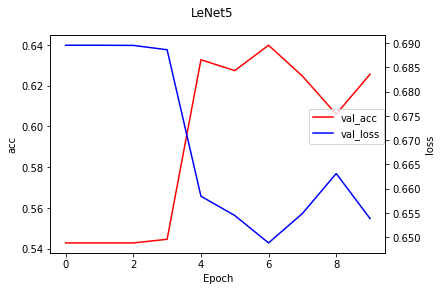

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

def history_plotter(history, title=''):
    
    fig, ax1 = plt.subplots()
    
    fig.suptitle(title)
    ax1.plot(history.history['val_acc'], label='val_acc', color='red')
    ax1.set_ylabel('acc')
    ax1.set_xlabel('Epoch')

    ax2 = ax1.twinx()
    ax2.plot(history.history['val_loss'], label='val_loss', color='blue')
    ax2.set_ylabel('loss')
    fig.legend(bbox_to_anchor=(0.4, 0, 0.5, 0.65))
    plt.show()

history_plotter(LeNet5_history, title='LeNet5')

From the results above we can see that the LeNet style network does not perform particularly well in this situation. This is likely because we do not have the depth in the network to catch the features representing the illnesses in the X-Rays. A few things to notice about this model:

- Time : it only takes around 20 s per epoch on my machine (i7-7700 hq + GTX 1050). In isolation this number doesn't mean much, but we can compare it to the time it takes to train the later models.

- Epochs : the training ended after 10 epochs. When compared to other models, this will give us an idea of how quickly the model converges.

Now we will check how the performace of the model changes with respect to the kernel size used and the number of filters.

In [ ]:
init_n_filters_list = [32, 24]
kernelsize_list = [3, 2]

LeNet5_dict = {}

for init_n_filters in init_n_filters_list:
    for kernelsize in kernelsize_list:
        print('now working on {} initial filters and kernelsize {}'.format(init_n_filters, kernelsize))
        
        # build the model
        model = make_LeNet5(print_model=False, init_n_filters=init_n_filters, kernelsize=kernelsize)
        
        # fit the model
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32),
                        epochs=50, verbose=1,
                        validation_data=(X_test,y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', 
                                                 patience=3,
                                                 restore_best_weights=True)]) # from 12. More Advanced CNN Techniques.ipynb
        
        # get y_hat
        y_hat = model.predict(X_train)
        
        # now append to dict
        name = 'LeNet_{}_{}'.format(init_n_filters, kernelsize)
        LeNet5_dict[name]=y_hat
        

now working on 32 initial filters and kernelsize 3
Epoch 1/50
 87/140 [=================>............] - ETA: 7s - loss: 0.6850 - acc: 0.5471

<a id="Ensembles"></a>

### Ensembles 

Now we will move onto Ensemble Nets. The basis for this code came from the course [github](https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb) with a few modifications. 

In [65]:
# now an ensemble net
# modified https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb

from keras.layers import average, concatenate
from keras.models import Input, Model
from keras.regularizers import l2

num_ensembles = 3
l2_lambda = 0.000001

def make_ensemble(size=256, print_model=False, num_ensembles=3, l2_lambda=0.000001, loss='binary_crossentropy',
                 init_n_filters=64, kernelsize=3):
    # wrap this in a function so that we can use cross-validation later
    input_holder = Input(shape=(size, size, 1))

    # start with a conv layer
    x = Conv2D(filters=init_n_filters,
               input_shape = (size,size,1),
               kernel_size=kernelsize,
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

    x = Conv2D(filters=int(0.8*init_n_filters),
               kernel_size=kernelsize,
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
    input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    branches = []
    for _ in range(num_ensembles):

        # start using NiN (MLPConv)
        x = Conv2D(filters=32,
                       input_shape = (size,size,1),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='linear', data_format="channels_last")(input_conv)

        x = Conv2D(filters=32,
                       kernel_size=(1,1),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu', data_format="channels_last")(x)

        x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

        x = Conv2D(filters=64,
                       input_shape = (size,size,1),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='linear', data_format="channels_last")(x)

        x = Conv2D(filters=64,
                       kernel_size=(1,1),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='linear', data_format="channels_last")(x)

        x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

        # add one layer on flattened output
        x = Flatten()(x)
        x = Dropout(0.25)(x) # add some dropout for regularization after conv layers
        x = Dense(128,       
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(l2_lambda)
                )(x)
        x = Dropout(0.25)(x)
        x = Dense(1, 
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(l2_lambda)
                 )(x)

        # now add this branch onto the master list
        branches.append(x)

    # that's it, we just need to average the results
    if num_ensembles != 1:
        x = concatenate(branches)

    x = Dense(1, 
          activation='sigmoid', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

    # here is the secret sauce for setting the network using the 
    #   Functional API:
    ensemble_model = Model(inputs=input_holder,outputs=x)
    
    ensemble_model.compile(loss=loss, # 'categorical_crossentropy' 'mean_squared_error' 'binary_crossentropy'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])
    
    if print_model:
        print(ensemble_model.summary())
    
    return ensemble_model

ensemble_model = make_ensemble(print_model=True, num_ensembles=num_ensembles, l2_lambda=l2_lambda, loss='binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_29[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 

In [66]:
ensemble_history = ensemble_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                                          steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                                          epochs=50, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
                                          )

K_clear_session()

Epoch 1/50
140/140 [==============================] - 59s 424ms/step - loss: 7.3316 - acc: 0.5429 - f1_score: nan - val_loss: 7.3709 - val_acc: 0.5428 - val_f1_score: nan
Epoch 2/50
140/140 [==============================] - 55s 395ms/step - loss: 4.4157 - acc: 0.5433 - f1_score: nan - val_loss: 0.6924 - val_acc: 0.5428 - val_f1_score: nan
Epoch 3/50
140/140 [==============================] - 55s 395ms/step - loss: 0.6917 - acc: 0.5429 - f1_score: nan - val_loss: 0.6909 - val_acc: 0.5428 - val_f1_score: nan
Epoch 4/50
140/140 [==============================] - 55s 395ms/step - loss: 0.6907 - acc: 0.5411 - f1_score: nan - val_loss: 0.6902 - val_acc: 0.5428 - val_f1_score: nan
Epoch 5/50
140/140 [==============================] - 55s 395ms/step - loss: 0.6904 - acc: 0.5391 - f1_score: nan - val_loss: 0.6898 - val_acc: 0.5428 - val_f1_score: nan
Epoch 6/50
140/140 [==============================] - 55s 394ms/step - loss: 0.6896 - acc: 0.5437 - f1_score: nan - val_loss: 0.6896 - val_acc: 0

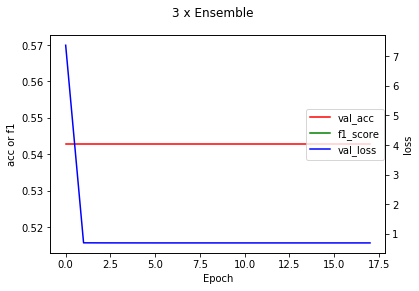

In [67]:
history_plotter(ensemble_history, title='3 x Ensemble')

From the above plot we can see that during the training we were able to decrease the loss function (binary cross-entropy). However the accuracy and the f1 score remained relatively constand during the training. We can also notice that

- Time : it took about 1 minute per epoch during training. This is about twice as long as the LeNet style archetecute. 

- Epochs : the training quit after 9 epochs. This is fewer than the LeNet style network.

- F1 score : the model was able to predict both classes at each epoch and therefore has a meaningful F1 score. The best F1 score was around 0.625.

Next we will look at how the number of ensembles (ensemble branches?) changes the results


working on 1 ensembles

Epoch 1/50
140/140 [==============================] - 37s 264ms/step - loss: 8.6583 - acc: 0.4569 - f1_score: 0.6221 - val_loss: 8.6533 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 2/50
140/140 [==============================] - 35s 251ms/step - loss: 8.6652 - acc: 0.4565 - f1_score: 0.6217 - val_loss: 8.6533 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 3/50
140/140 [==============================] - 35s 251ms/step - loss: 8.5906 - acc: 0.4611 - f1_score: 0.6262 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 4/50
140/140 [==============================] - 35s 251ms/step - loss: 8.7041 - acc: 0.4540 - f1_score: 0.6187 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 5/50
140/140 [==============================] - 35s 251ms/step - loss: 8.6191 - acc: 0.4594 - f1_score: 0.6245 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 6/50
140/140 [==============================] - 35s 251ms/step - loss: 8.6794 - acc:

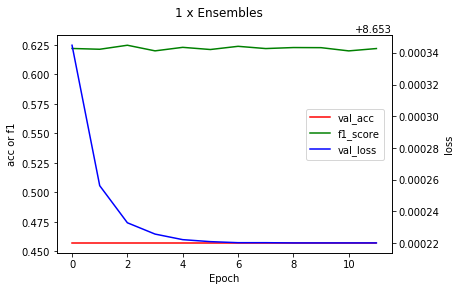


working on 2 ensembles

Epoch 1/50
140/140 [==============================] - 48s 343ms/step - loss: 8.6621 - acc: 0.4567 - f1_score: 0.6224 - val_loss: 8.6534 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 2/50
140/140 [==============================] - 45s 324ms/step - loss: 8.6156 - acc: 0.4596 - f1_score: 0.6247 - val_loss: 8.6533 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 3/50
140/140 [==============================] - 45s 323ms/step - loss: 8.7146 - acc: 0.4534 - f1_score: nan - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 4/50
140/140 [==============================] - 45s 324ms/step - loss: 8.6579 - acc: 0.4569 - f1_score: 0.6222 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 5/50
140/140 [==============================] - 45s 323ms/step - loss: 8.6970 - acc: 0.4545 - f1_score: 0.6198 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 6/50
140/140 [==============================] - 45s 324ms/step - loss: 8.5869 - acc: 0.

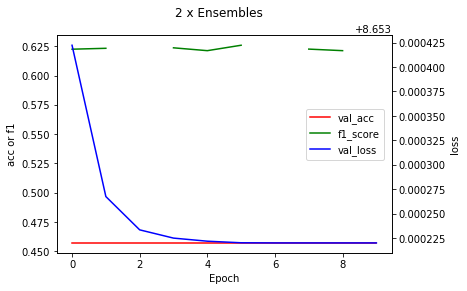


working on 3 ensembles

Epoch 1/50
140/140 [==============================] - 59s 424ms/step - loss: 8.6587 - acc: 0.4569 - f1_score: 0.6228 - val_loss: 8.6535 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 2/50
140/140 [==============================] - 56s 398ms/step - loss: 8.6617 - acc: 0.4567 - f1_score: 0.6217 - val_loss: 8.6533 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 3/50
140/140 [==============================] - 56s 397ms/step - loss: 8.6543 - acc: 0.4572 - f1_score: 0.6227 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 4/50
140/140 [==============================] - 56s 398ms/step - loss: 8.6723 - acc: 0.4560 - f1_score: 0.6213 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 5/50
140/140 [==============================] - 56s 398ms/step - loss: 8.6013 - acc: 0.4605 - f1_score: 0.6253 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 6/50
140/140 [==============================] - 56s 397ms/step - loss: 8.7146 - acc:

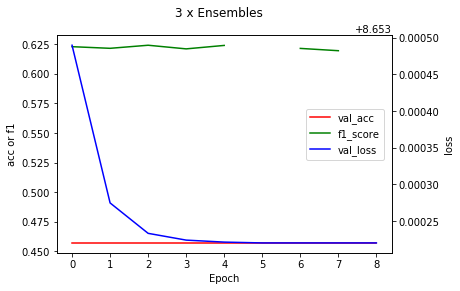


working on 4 ensembles

Epoch 1/50
140/140 [==============================] - 70s 504ms/step - loss: 8.6554 - acc: 0.4571 - f1_score: 0.6216 - val_loss: 8.6536 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 2/50
140/140 [==============================] - 66s 470ms/step - loss: 8.6651 - acc: 0.4565 - f1_score: 0.6218 - val_loss: 8.6533 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 3/50
140/140 [==============================] - 66s 470ms/step - loss: 8.6581 - acc: 0.4569 - f1_score: 0.6220 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 4/50
140/140 [==============================] - 66s 468ms/step - loss: 8.6580 - acc: 0.4569 - f1_score: 0.6224 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 5/50
140/140 [==============================] - 66s 470ms/step - loss: 8.6226 - acc: 0.4591 - f1_score: 0.6230 - val_loss: 8.6532 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 6/50
140/140 [==============================] - 66s 469ms/step - loss: 8.6792 - acc:

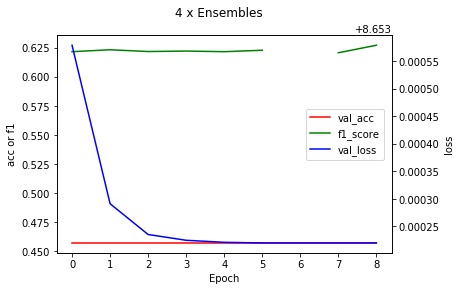


working on 5 ensembles

Epoch 1/50
 98/140 [====================>.........] - ETA: 23s - loss: 8.5471 - acc: 0.4640 - f1_score: 0.6286

ResourceExhaustedError: OOM when allocating tensor with shape[32,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/RMSprop/gradients/conv2d_2/convolution_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [25]:
num_ensembles_list = [1, 2, 3, 4]

hist_dict = {}

for n in num_ensembles_list:
    print('\nworking on {} ensembles\n'.format(n))
    ensemble_model = make_ensemble(print_model=False, num_ensembles=n, l2_lambda=l2_lambda)
    
    history = ensemble_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                                          steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                                          epochs=50, verbose=1, # verbose 0: silent, 1: progress bar, 2: 1 line per epoch
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
                                          )
    
    hist_dict[n] = history
    # save the histories to a dictionary so that we can access them for later analysis
    
    history_plotter(history, title='{} x Ensembles'.format(n))
    
    K_clear_session()

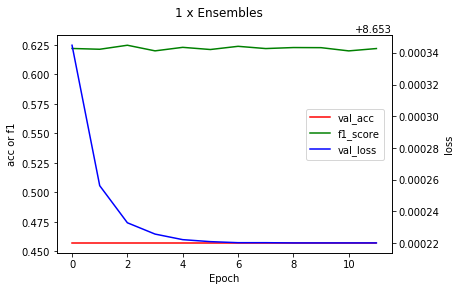

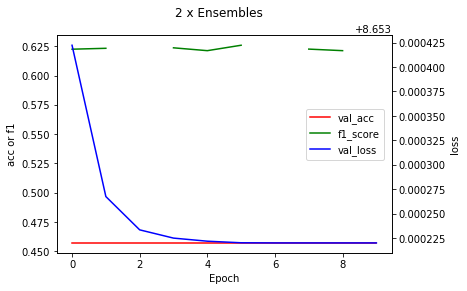

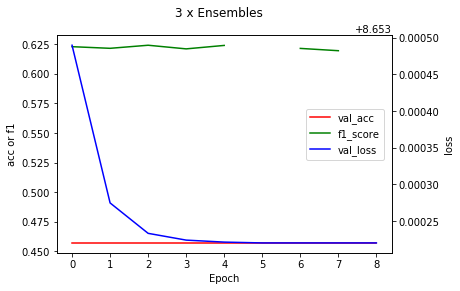

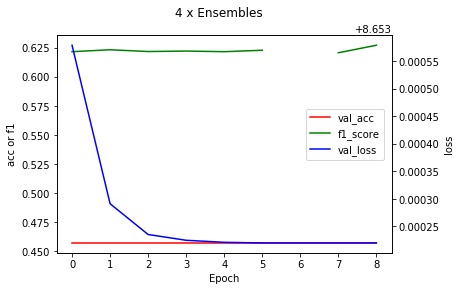

In [26]:
for k, v in hist_dict.items():
    history_plotter(v, title='{} x Ensembles'.format(k))

In [73]:
# Now try XCeption
# modified from https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb

from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Activation
from keras.layers import average, concatenate
from keras.models import Input, Model

l2_lambda = 0.000001

def make_xception(size=256, print_model=False, l2_lambda=0.000001, loss='binary_crossentropy', kernelsize=3, init_n_filters=64):

    input_holder = Input(shape=(size, size, 1))

    # start with a conv layer
    x = Conv2D(filters=init_n_filters,
                   input_shape = (size,size,1),
                   kernel_size=kernelsize,
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(input_holder)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=int(0.8*init_n_filters),
                   kernel_size=kernelsize,
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)


    x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = SeparableConv2D(filters=32,
                   input_shape = (size,size,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   depth_multiplier = 1, # controls output channels
                   data_format="channels_last")(x_split)


    x_split = Add()([x, x_split])

    x = SeparableConv2D(filters=32,
                   input_shape = (size,size,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   depth_multiplier = 1, # controls output channels
                   data_format="channels_last")(x_split)


    x_split = Add()([x, x_split])


    x = Activation("relu")(x_split)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(1,activation="sigmoid")(x)

    xception = Model(inputs=input_holder,outputs=x)
    
    xception.compile(loss=loss, # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='rmsprop', # 'adadelta' 'rmsprop'
                    metrics=['accuracy']) 

    if print_model:
        print(xception.summary())
        
    return xception
        
xception = make_xception(print_model=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 32) 9248        max_pooling2d_10[0][0]           
__________________________________________________________________________________________________
max_poolin

In [74]:
xception_history = xception.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                                          steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                                          epochs=50, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
                                          )

K_clear_session()

Epoch 1/50
140/140 [==============================] - 24s 170ms/step - loss: 4.6864 - acc: 0.5504 - f1_score: nan - val_loss: 0.6892 - val_acc: 0.5490 - val_f1_score: nan
Epoch 2/50
140/140 [==============================] - 22s 159ms/step - loss: 0.6807 - acc: 0.5826 - f1_score: nan - val_loss: 0.6673 - val_acc: 0.6123 - val_f1_score: nan
Epoch 3/50
140/140 [==============================] - 22s 159ms/step - loss: 0.6755 - acc: 0.5958 - f1_score: nan - val_loss: 0.6578 - val_acc: 0.6150 - val_f1_score: nan
Epoch 4/50
140/140 [==============================] - 22s 158ms/step - loss: 0.6769 - acc: 0.5978 - f1_score: 0.4863 - val_loss: 0.6586 - val_acc: 0.6283 - val_f1_score: nan
Epoch 5/50
140/140 [==============================] - 22s 159ms/step - loss: 0.6705 - acc: 0.6024 - f1_score: 0.5091 - val_loss: 0.6526 - val_acc: 0.6337 - val_f1_score: nan
Epoch 6/50
140/140 [==============================] - 22s 159ms/step - loss: 0.6716 - acc: 0.5973 - f1_score: nan - val_loss: 0.6569 - val_

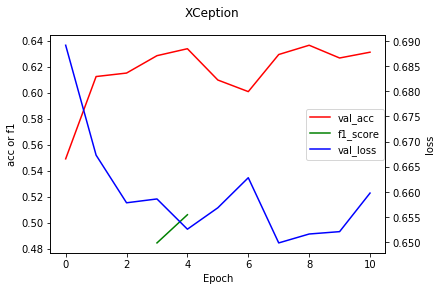

In [75]:
history_plotter(xception_history, title='XCeption')

In [77]:
# finally, some Resnet style bypass
# also from https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

def make_resnet(size=256, print_model=False, loss='binary_crossentropy', kernelsize=3, init_n_filters=64):

    input_holder = Input(shape=(size, size, 1))

    # start with a conv layer
    x = Conv2D(filters=init_n_filters,
                   input_shape = (size,size,1),
                   kernel_size=kernelsize,
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(input_holder)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=int(0.8*init_n_filters),
                   kernel_size=kernelsize,
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x_split)

    x = Conv2D(filters=64,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    # now add back in the split layer, x_split (residual added in)
    x = Add()([x, x_split])
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)

    resnet = Model(inputs=input_holder,outputs=x)

    resnet.compile(loss=loss, # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='rmsprop', # 'adadelta' 'rmsprop'
                    metrics=['accuracy'])

    if print_model:
        print(resnet.summary())
    
    return resnet

resnet=make_resnet(print_model=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 32) 9248        max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

In [78]:
resnet_history = resnet.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                                          steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                                          epochs=50, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
                                          )

K_clear_session()

Epoch 1/50
140/140 [==============================] - 22s 157ms/step - loss: 8.6147 - acc: 0.4567 - f1_score: 0.6202 - val_loss: 8.6536 - val_acc: 0.4572 - val_f1_score: 0.6230
Epoch 2/50
140/140 [==============================] - 20s 146ms/step - loss: 6.4530 - acc: 0.4850 - f1_score: nan - val_loss: 0.6623 - val_acc: 0.6301 - val_f1_score: nan
Epoch 3/50
140/140 [==============================] - 20s 145ms/step - loss: 0.6870 - acc: 0.5808 - f1_score: nan - val_loss: 0.6522 - val_acc: 0.6337 - val_f1_score: nan
Epoch 4/50
140/140 [==============================] - 20s 145ms/step - loss: 0.6758 - acc: 0.5888 - f1_score: nan - val_loss: 0.6472 - val_acc: 0.6480 - val_f1_score: nan
Epoch 5/50
140/140 [==============================] - 20s 145ms/step - loss: 0.6687 - acc: 0.6094 - f1_score: nan - val_loss: 0.6492 - val_acc: 0.6569 - val_f1_score: nan
Epoch 6/50
140/140 [==============================] - 20s 145ms/step - loss: 0.6700 - acc: 0.6049 - f1_score: nan - val_loss: 0.6313 - val_

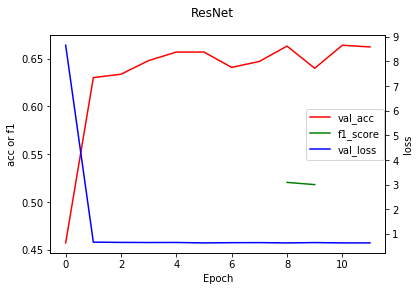

In [79]:
history_plotter(resnet_history, title='ResNet')

<a id="visualize"></a>

### Visualize Final Results

> __[15 points]__ Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 

In [ ]:
# train eacy type of model multiple times
# get final metric
# compare the distributions of final metrics

<a id="compare"></a>

### Compare the Perfomace

> __[10 points]__ Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

In [ ]:
# same as above, train multiple and compare distributions of final metrics?

<a id="exceptional"></a>

## Exceptional Work

<a id="additional_analyses"></a>

### Additional Analyses

> You have free reigh to provide additional analyses.

<a id="CAM"></a>

#### Class Activation Maps

In addition to simply predicting whether or not a patient has one of the conditions, it may also be useful to know which sections of the X Ray were most indicative of the condition. To extract this information we will add heatmaps to the images using class activation mappings (CAMs). In order to do this we need to

- construct a new model using the last convolution layer of the full predicting model as the output. In principle, we should probably try to extract the information directly from the original model to save resources. However, creating a new model allows us to get this information more easily.

- resize the extraced information. If we want to overlay the heatmap ontop of the original image we need to make them the same size. We will also potentially need to convert the datatype for the image manipulation packages to work.

- add the heatmap to the original image. Since we are adding a color heatmap onto a black and white X-Ray, we will need to be careful with this addition.

- display and/or save the compound image as necessary.

In [75]:
from keras import activations

CAM_model = Model(inputs=LeNet5.input, outputs=LeNet5.get_layer('CAM_Layer').output)
#CAM_model.get_layer('CAM_Layer').activation = activations.sigmoid

CAM_data = CAM_model.predict(X_train)

In [76]:
from scipy.ndimage import zoom

factor = X_train[0].shape[0]/CAM_data[0].shape[0]
print(factor)

print(CAM_data[0].shape)
CAM_data_up = np.array([zoom(x, (factor, factor, 1), order=1) for x in CAM_data])
print(CAM_data_up[0].shape)

4.266666666666667
(60, 60, 1)
(256, 256, 1)


3838


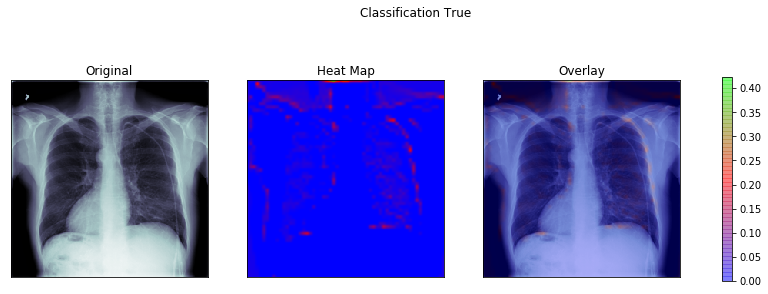

In [77]:
import matplotlib.pyplot as plt
from numpy.random import random
from IPython.display import clear_output
import time

def plot_CAM(idx, CAM_data_up, X_train):
    clear_output(wait=True)
    print(idx)

    data = CAM_data_up[idx][:,:,0]

    fig = plt.figure(figsize = (15,5))
    fig.suptitle('Classification {}'.format(y_sick[idx]))

    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(X_train[idx][:,:,0], cmap='bone')
    ax1.set(xticks=[], yticks=[], title='Original')

    ax2 = fig.add_subplot(1,3,2)
    im = ax2.imshow(data, cmap='brg', interpolation='nearest', alpha=1)
    ax2.set(xticks=[], yticks=[], title='Heat Map')
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(X_train[idx][:,:,0], cmap='bone')
    im = ax.imshow(data, cmap='brg', interpolation='nearest', alpha=0.3)
    ax.set(xticks=[], yticks=[], title='Overlay')
    fig.colorbar(im, ax=[ax,ax1,ax2], shrink=.75) # 'steal' space from all of the axes...

    plt.show()
    time.sleep(3)

n_plot = 7
for _ in range(n_plot):
    ix = int(random()*len(X_train))
    plot_CAM(ix, CAM_data_up, X_train)
    
#plot_CAM(326, CAM_data_up, X_train)

(256, 256, 1)
(256, 256)


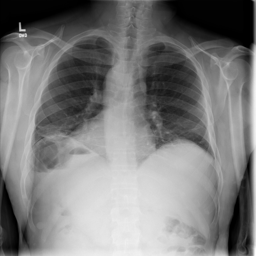

In [32]:
print(X_train[0].shape)

img=X_train[0,:,:]
img = img[:,:,0]
img = ((img+0.5)*255).astype('uint8')

print(img.shape)

im = Image.fromarray(img)

display(im)

<a id="image_generator"></a>

### Custom Image Generator

For the random sample of the NIH chest XRay data we can generally hold all of the image data being used in memory. For 5606 images of size 256$\times$256 we only need a little over 1 GB of memory. However, the full dataset has 112,120 images and would require around 20 GB of memory. Since not all computers have this much RAM, it may be necessary to read in the images as they are used instead of reading them all in at once and holding them in memory. We accomplish this by writing a custom image generator used in the `model.fit_generator` call. For now we use the keras `ImageDataGenerator` to handle the pertubations to the images. If needed we could use PIL or OpenCV to accomplish this.

In [ ]:
def generate_data(full_image_list, full_label_list, batch_size=32, image_path='.', size=256, augment=None):
    if len(full_image_list) != len(full_label_list):
        print('image list length and label list length do not match')
    
    # get the indices of batch size
    indices = np.random.choice(len(full_image_list), batch_size, replace=False)
    
    # get lists at the indices
    image_name_list = [full_image_list[i] for i in indices]
    label_list = [full_label_list[i] for i in indices]
    
    # now get the image data
    image_dat_list = np.empty([batch_size, size, size, 1], dtype=np.float32) # preallocate
    image_dat_list[:,:,:,0] = 1 # always 1 channel for us
    for index in range(len(image_name_list)):
        name = image_name_list[index]
        img = Image.open(os.path.join(image_path, name))
        image_dat_list[index,:,:,0] = np.array(img)/255.0-0.5
    
    # use the data-augmentation if requested
    if augment is not None:
        image_dat_list, label_list = next(augment.flow(image_dat_list, label_list, batch_size = batch_size))
    
    # now yield results
    yield(image_dat_list, label_list)

In [ ]:
from sklearn.model_selection import train_test_split

male_df = df[df['Patient Gender']=='M']

# build a new target
male_y_sick = ~male_df['Finding Labels'].str.contains('No Finding')

# new test/train split
dat_train_male, dat_test_male, y_train_male, y_test_male = train_test_split(male_df, male_y_sick, test_size=0.2, 
                                                                            random_state=42, stratify=male_y_sick)

male_df.head()

In [ ]:
%matplotlib inline
from PIL import Image
import time
import os
from IPython.display import display, clear_output
# load the images. this is going to take a fair amount of memory...


size = 256

size_dict = {64:  '64x64',
             128: '128x128',
             256: '256x256',
             512: '512x512',
             1024:'1024x1024'}
path = os.path.join(os.getcwd(), 'sample', size_dict[size])

X_test_male = np.empty([len(dat_test_male), size, size, 1], dtype=np.float32) # preallocate
X_train_male = np.empty([len(dat_train_male), size, size, 1], dtype=np.float32) # num_images, img_width, img_height, num_channels

X_test_male[:,:,:,0]=1
X_train_male[:,:,:,0]=1

index = 0
t_start = time.time()
for name in dat_test_male['Image Index']:
    clear_output(wait=True)
    print('working on test {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(os.path.join(path, name))
    display(img)
    X_test[index,:,:,0] = np.array(img)/255.0-0.5
    index+=1

index = 0
t_start = time.time()
for name in dat_train_male['Image Index']:
    clear_output(wait=True)
    print('working on train {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(os.path.join(path, name))
    display(img)
    X_train[index,:,:,0] = np.array(img)/255.5-0.5
    index+=1

In [ ]:
from keras.models import clone_model

male_model = clone_model(model, input_tensors=None)
male_model.summary()

# male_model.compile(loss='binary_crossentropy',
#                   optimizer='rmsprop',
#                   metrics=['accuracy'])


# history = male_model.fit_generator(datagen.flow(X_train_male, y_train_male, batch_size=32), 
#                             steps_per_epoch=int(len(X_train_male)/32),
#                             epochs=15, verbose=1,
#                             validation_data=(X_test_male,y_test_male),
#                             callbacks=[EarlyStopping(monitor='val_loss', patience=2)] # from 12. More Advanced CNN Techniques.ipynb
#                             )

<a id="Transfer_Learning"></a>

### Transfer Learning

> One idea (__required for 7000 level students__): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance.

<a id="thoughts"></a>

## Final Thoughts

